In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [26]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [27]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [28]:
def load_data():
    data = pd.read_csv('data/train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [29]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [24]:
!pip install scikit-learn

In [30]:
train_x['Temp']
train_x['Wind']
train_x['Moisture']
train_x['Precipitation']
train_x['Sun']
train_y

0     8179.056
1     8135.640
2     8107.128
3     8048.808
4     8043.624
        ...   
83    8386.416
84    8435.664
85    8591.184
86    8638.488
87    8663.112
Name: Wh, Length: 88, dtype: float64

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 도메인 지식 고려해보면 온도와 전기세가 가장 관련있을 확률이 높다고 생각됨. 이에 따라 분석 진행.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [31]:
# 사용할 패키지를 import!
from sklearn.preprocessing import StandardScaler

In [32]:
scaler=StandardScaler()
train_x2 = train_x['Temp']
train_x2 = np.expand_dims(train_x2 ,axis=1)
train_x2.shape
train_y2 = np.expand_dims(train_y ,axis=1)
train_y2.shape

(88, 1)

In [33]:
scaler = StandardScaler()
scaler = scaler.fit(train_x2)
processed_data = scaler.transform(train_x2)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [34]:
from sklearn.linear_model import LinearRegression

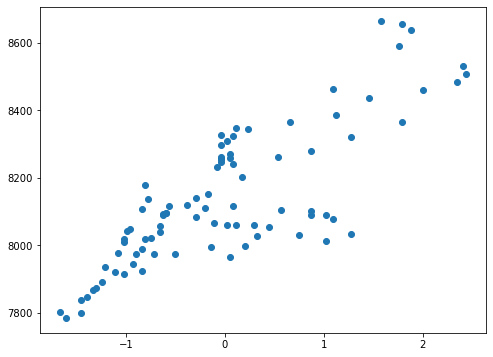

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(processed_data,train_y2)
plt.show()

In [36]:
linear_model = LinearRegression().fit(processed_data,train_y2)


## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [37]:
linear_pred_y = linear_model.predict(processed_data)

linear_beta = linear_model.coef_[0][0]
linear_intercept = linear_model.intercept_[0]
print(f"Beta :{linear_beta: .4f}")
print(f"Intercept : {linear_intercept: .4f}")

Beta : 162.6602
Intercept :  8142.1863


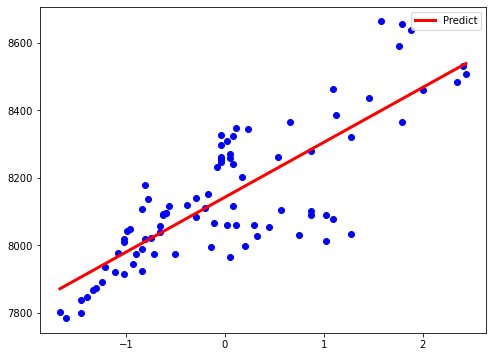

In [38]:
x_axis = np.linspace(np.min(processed_data), np.max(processed_data), 100)
linear_fit = linear_beta * x_axis + linear_intercept

plt.figure(figsize=(8,6))
plt.plot(x_axis, linear_fit, label='Predict', c='r', linewidth=3)
plt.scatter(processed_data,train_y2, c='blue')
plt.legend()
plt.show()

# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [39]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [40]:
train_mse = mse(linear_pred_y, train_y2)
print(f"Linear {train_mse:.5f}")

Linear 14543.75828


In [20]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

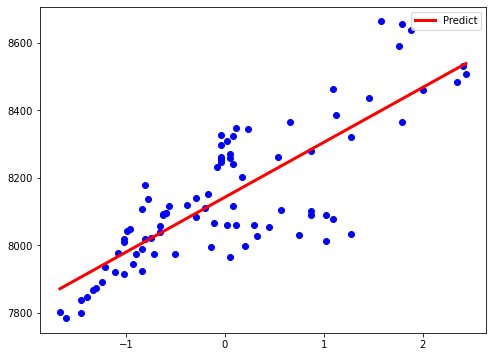

In [43]:
# visualization 하실 분은 진행해주세요!
visualize(linear_model,processed_data, train_y2)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [48]:
# transform을 하시는 분들은 실행해주세요
# test_x = 
test_x2 = test_x['Temp']
test_x2 = np.expand_dims(test_x2 ,axis=1)
processed_test = scaler.transform(test_x2)
test_y2 = np.expand_dims(test_y ,axis=1)

In [49]:
# y1_hat에 predict값 할당
pred_y = linear_model.predict(processed_test)
 

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [50]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [52]:
test_mse = mse(pred_y, test_y2)
print(f"Linear {test_mse:.5f}")

Linear 198060.52184


In [53]:
score(train_mse,test_mse)

 13.6182


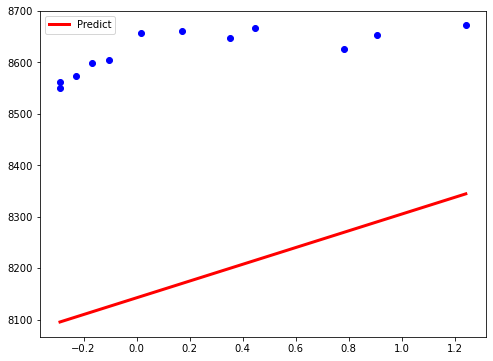

In [56]:
 visualize(linear_model, processed_test, test_y2)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!